In [1]:
%%capture
!pip install pydicom

import cv2
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import pydicom
import zipfile

from google.colab import drive
drive.mount("/content/drive")

In [3]:
path = "/content/drive/MyDrive/PyTorch_Vol3/rsna-pneumonia-detection-challenge.zip"
zip_file = zipfile.ZipFile(file = path, mode = "r")
zip_file.extractall()
zip_file.close()

In [4]:
labels = pd.read_csv("/content/stage_2_train_labels.csv")
labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [5]:
print("Shape : ", labels.shape)

Shape :  (30227, 6)


In [6]:
ROOT_PATH = Path("/content/stage_2_train_images/")
SAVE_PATH = Path("/content/Processed/")
ROOT_PATH,SAVE_PATH

(PosixPath('/content/stage_2_train_images'), PosixPath('/content/Processed'))

In [7]:
c = 0
labels.patientId.iloc[c]

'0004cfab-14fd-4e49-80ba-63a80b6bddd6'

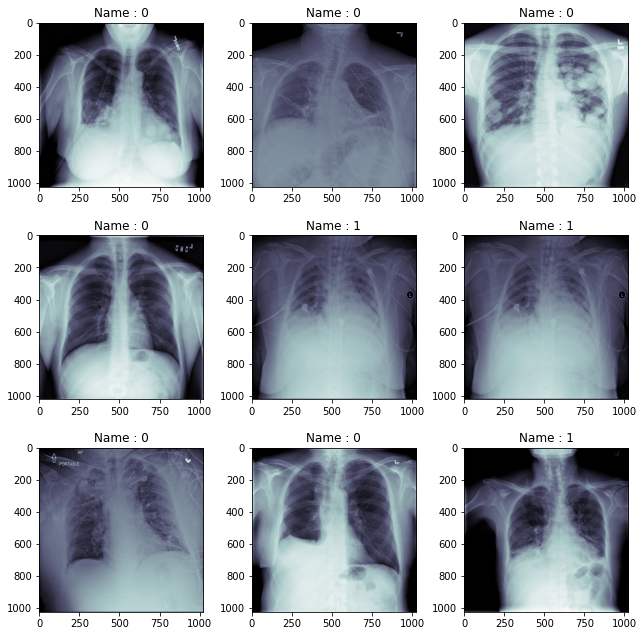

In [9]:
fig, axis = plt.subplots(3,3, figsize = (9,9))
c = 0
axis = axis.ravel()

for i in range(len(axis)):

    patient_id = labels.patientId.iloc[c]
    dcm_path = ROOT_PATH/patient_id
    dcm_path = dcm_path.with_suffix(".dcm")
    dcm = pydicom.read_file(dcm_path).pixel_array

    label = labels["Target"].iloc[c]

    axis[i].imshow(dcm, cmap = "bone")
    axis[i].set_title(f"Name : {label}")
    c+=1

plt.tight_layout()
plt.show()

In [10]:
ROOT_PATH,SAVE_PATH

(PosixPath('/content/stage_2_train_images'), PosixPath('/content/Processed'))

In [12]:
sums, sums_squared = 0, 0

for c , patient_id in enumerate(tqdm(labels.patientId)):

    patient_id = labels.patientId.iloc[c]
    dcm_path = ROOT_PATH/patient_id
    dcm_path = dcm_path.with_suffix(".dcm")
    dcm = pydicom.read_file(dcm_path).pixel_array / 255

    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)

    label = labels.Target.iloc[c]

    train_or_val = "train" if c < 24000 else "val"

    # Burda klasör oluşuyor !!!

    current_save_path = SAVE_PATH/train_or_val/str(label)
    current_save_path.mkdir(parents = True, exist_ok = True)

    np.save(current_save_path/patient_id, dcm_array)

    normalizer = 224*224
    if train_or_val == "train":
        sums+=np.sum(dcm_array) / normalizer
        sums_squared+=(dcm_array ** 2).sum() / normalizer

  0%|          | 0/30227 [00:00<?, ?it/s]

In [13]:
sums,sums_squared

(11733.810507015298, 7191.2687539859335)

In [14]:
mean = sums / 24000
std = np.sqrt((sums_squared / 24000) - mean ** 2)

print(f"Mean of Dataset: {mean}, STD: {std}")

(0.4889087711256374, 0.24617963278704907)

---

In [15]:
%%capture
!pip install torchmetrics
!pip install pytorch-lightning

In [16]:
import torch
import torch.nn as nn
from torchvision import transforms,datasets,models
from torch.utils.data import DataLoader,TensorDataset
from torchvision.utils import make_grid

import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [18]:
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean , std),
                                       transforms.RandomAffine(degrees = (-5, 5), translate = (0, 0.05), scale = (0.9,1.1)),
                                       transforms.RandomResizedCrop((224,224), scale = (0.35,1))
])

val_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean , std)
])

In [19]:
train_dataset = datasets.DatasetFolder("/content/Processed/train", loader = load_file,extensions = "npy",transform = train_transforms )
val_dataset = datasets.DatasetFolder("/content/Processed/val" , loader = load_file, extensions = "npy", transform = val_transforms)

In [20]:
len(train_dataset),len(val_dataset)

(20993, 5691)

In [22]:
train_dataset[0][0].shape,train_dataset[0][1]

(torch.Size([1, 224, 224]), 0)

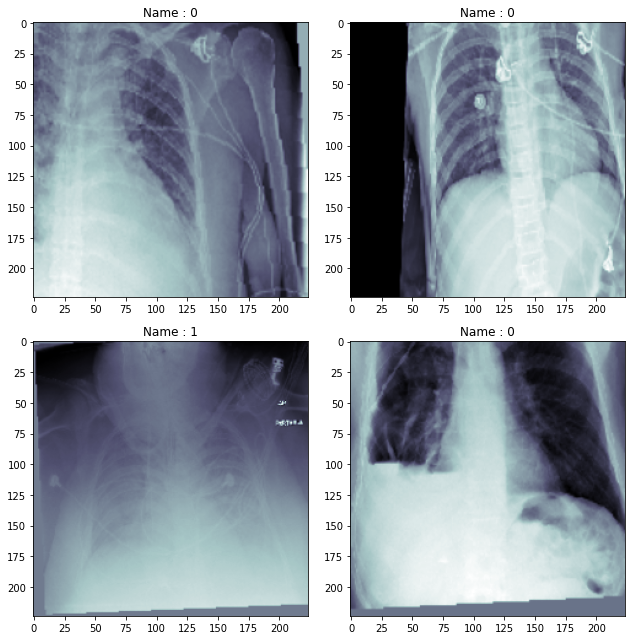

In [23]:
fig , axis = plt.subplots(2,2,figsize = (9,9))

axis = axis.ravel()

for i in range(len(axis)):

    random_index = np.random.randint(0,24000)
    x_ray,label = train_dataset[random_index]
    axis[i].imshow(x_ray[0], cmap = "bone")
    axis[i].set_title(f"Name : {label}")

plt.tight_layout()
plt.show()

In [24]:
batch_size = 64
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [25]:
np.unique(train_dataset.targets,return_counts = True)

(array([0, 1]), array([16008,  4985]))

In [26]:
np.unique(val_dataset.targets,return_counts = True)

(array([0, 1]), array([4664, 1027]))

In [27]:
models.resnet18().conv1,models.resnet18().fc

(Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Linear(in_features=512, out_features=1000, bias=True))

In [28]:
class PneumoniaModel(pl.LightningModule):

    def __init__(self, weight = 1):
        super().__init__()

        self.model = models.resnet18()
        self.model.conv1 = nn.Conv2d(1,64, kernel_size = (7,7), stride = (2,2), padding = (3,3), bias = False)
        self.model.fc = nn.Linear(in_features = 512, out_features = 1, bias = True)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = 1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor([weight]))

        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()

    def forward(self,data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):

        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]
        loss = self.loss_fn(pred, label)

        self.log("Train Loss", loss)
        self.log("Step Train ACC", self.train_acc(torch.sigmoid(pred), label.int()))

        return loss
 
    def validation_step(self, batch, batch_idx):

        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]
        loss = self.loss_fn(pred, label)

        self.log("Validation Loss", loss)
        self.log("Step Val ACC", self.val_acc(torch.sigmoid(pred), label.int()))

        return loss

    def validation_epoch_end(self, outs):
        self.log("Val ACC", self.val_acc.compute())
    
    def configure_optimizers(self):
        return [self.optimizer]

In [103]:
model = PneumoniaModel()

In [31]:
# We create a checkpoint callback which only stores the 10 best models based on the validation accuracy.

checkpoint_callback = ModelCheckpoint(
    monitor = "Val Acc",
    save_top_k = 10,
    mode = "max"
)

In [32]:
gpus = 0
trainer = pl.Trainer(gpus = gpus, logger = TensorBoardLogger(save_dir = "./logs"), 
                     log_every_n_steps = 1, max_epochs = 35)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [33]:
trainer.fit(model, train_loader, val_loader)

Missing logger folder: ./logs/default

  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 11.2 M
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | Accuracy          | 0     
3 | val_acc   | Accuracy          | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [104]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [105]:
model = PneumoniaModel.load_from_checkpoint("/content/04-Pneumonia-Classification/weights/weights_3.ckpt")
model.eval()
model.to(device)

PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [106]:
for data, label in val_dataset:
    break

In [107]:
data.shape,data.unsqueeze(0).shape, np.array(label).shape

(torch.Size([1, 224, 224]), torch.Size([1, 1, 224, 224]), ())

In [41]:
preds = []
labels = []

with torch.no_grad():

    for data,label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)

preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/5691 [00:00<?, ?it/s]

In [44]:
len(preds),len(labels)

(5691, 5691)

In [108]:
acc = torchmetrics.Accuracy()(preds, labels)
precission = torchmetrics.Precision()(preds, labels)
recall = torchmetrics.Recall()(preds, labels)

cm = torchmetrics.ConfusionMatrix(num_classes = 2)(preds, labels)

print(f"Val Accuracy : {acc}")
print(f"Val Precission : {precission}")
print(f"Val Recall : {recall}")
print()
print(f"Confusion Matrix :\n {cm}")

Val Accuracy : 0.7394130825996399
Val Precission : 0.4001751244068146
Val Recall : 0.8899707794189453

Confusion Matrix :
 tensor([[3294, 1370],
        [ 113,  914]])


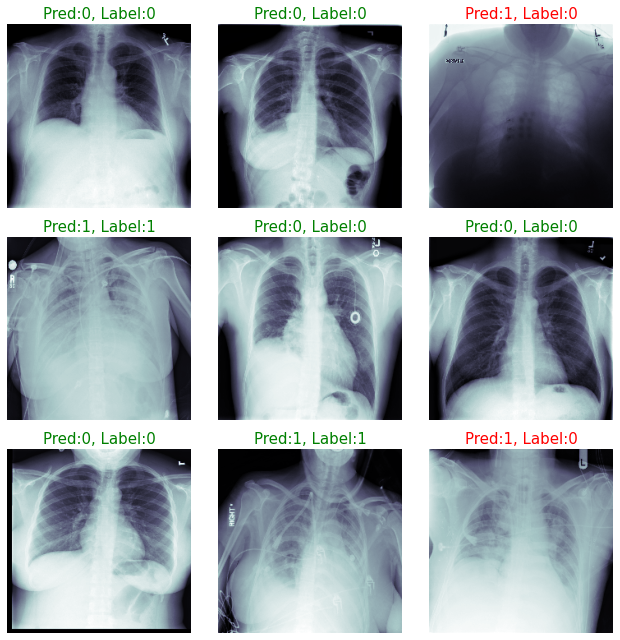

In [113]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

axis = axis.ravel()

for i in range(len(axis)):
        rnd_idx = np.random.randint(0, len(preds))
        axis[i].imshow(val_dataset[rnd_idx][0][0], cmap="bone")
        axis[i].set_title(f"Pred:{int(preds[rnd_idx] > 0.5)}, Label:{labels[rnd_idx]}",
                          color = ("green" if preds[rnd_idx].round() == labels[rnd_idx] else "red"),
                          fontsize = 15)
        axis[i].axis("off")

plt.tight_layout()
plt.show()

----

In [45]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [46]:
val_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean, std)])

In [47]:
val_dataset = datasets.DatasetFolder("/content/Processed/val", loader = load_file, extensions = "npy", transform = val_transforms)

In [48]:
temp_model = models.resnet18()

In [49]:
list(temp_model.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [68]:
random = torch.randint(0,1,size = [1,3,224,224]).float()
random.shape

torch.Size([1, 3, 224, 224])

In [70]:
nn.Sequential(*list(temp_model.children())[:-2])(random).shape

torch.Size([1, 512, 7, 7])

In [72]:
nn.functional.adaptive_avg_pool2d(nn.Sequential(*list(temp_model.children())[:-2])(random), output_size = (1,1)).shape

torch.Size([1, 512, 1, 1])

In [74]:
torch.flatten(nn.functional.adaptive_avg_pool2d(nn.Sequential(*list(temp_model.children())[:-2])(random), output_size = (1,1))).shape

torch.Size([512])

In [122]:
class PneumoniaModel2(pl.LightningModule):

    def __init__(self):

        super().__init__()
        self.model = models.resnet18()
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size = (7,7), stride = (2,2), padding = (3,3), bias = False)
        self.model.fc = nn.Linear(in_features = 512, out_features = 1)
        
        self.feature_map = nn.Sequential(*list(self.model.children())[:-2])

    def forward(self, data):

        feature_map = self.feature_map(data)
        avg_pool_output = nn.functional.adaptive_avg_pool2d(input = feature_map, output_size = (1,1))
        avg_output_flattened = torch.flatten(avg_pool_output)
        pred = self.model.fc(avg_output_flattened)

        return pred, feature_map

In [123]:
model = PneumoniaModel2.load_from_checkpoint("/content/04-Pneumonia-Classification/weights/weights_3.ckpt",
                                             strict=False)

model.eval();

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/saving.py:209: UserWarning: Found keys that are in the model state dict but not in the checkpoint: ['feature_map.0.weight', 'feature_map.1.weight', 'feature_map.1.bias', 'feature_map.1.running_mean', 'feature_map.1.running_var', 'feature_map.4.0.conv1.weight', 'feature_map.4.0.bn1.weight', 'feature_map.4.0.bn1.bias', 'feature_map.4.0.bn1.running_mean', 'feature_map.4.0.bn1.running_var', 'feature_map.4.0.conv2.weight', 'feature_map.4.0.bn2.weight', 'feature_map.4.0.bn2.bias', 'feature_map.4.0.bn2.running_mean', 'feature_map.4.0.bn2.running_var', 'feature_map.4.1.conv1.weight', 'feature_map.4.1.bn1.weight', 'feature_map.4.1.bn1.bias', 'feature_map.4.1.bn1.running_mean', 'feature_map.4.1.bn1.running_var', 'feature_map.4.1.conv2.weight', 'feature_map.4.1.bn2.weight', 'feature_map.4.1.bn2.bias', 'feature_map.4.1.bn2.running_mean', 'feature_map.4.1.bn2.running_var', 'feature_map.5.0.conv1.weight', 'feature_map.5.0.bn1.weight', 'fe

In [126]:
random1 = torch.randint(0,1,size = [512,49]).float()
random2 = torch.randint(0,1,size = [512]).float()
torch.matmul(random2,random1).shape

torch.Size([49])

In [124]:
np.array(list(model.model.fc.parameters()))[0].detach().shape

torch.Size([1, 512])

In [125]:
np.array(list(model.model.fc.parameters()))[0].detach()[0].shape

torch.Size([512])

In [129]:
for img, label in val_dataset:
    break

img.shape,np.array(label)

(torch.Size([1, 224, 224]), array(0))

In [130]:
test1, test2 = model(img.unsqueeze(0))

In [131]:
test1, test2.shape

(tensor([-0.6769], grad_fn=<AddBackward0>), torch.Size([1, 512, 7, 7]))

In [117]:
def cam(model,img):
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))

    # Features Size --> 1,512,7,7
    features = features.reshape((512,49))
    weight_params = list(model.model.fc.parameters())[0]
    weight = weight_params[0].detach()
    
    # Weight Size -- > 512
    # New Features Size -- > 512,49
    cam = torch.matmul(weight, features)
    cam_img = cam.reshape(7,7).cpu()

    return cam_img, torch.sigmoid(pred)

In [132]:
def visualize(img, cam, pred, label):

    img = img[0]
    cam = transforms.functional.resize(cam.unsqueeze(0), (224,224))[0]

    fig, axis = plt.subplots(1,2, figsize = (15,15))
    axis[0].imshow(img,cmap = "bone")
    axis[0].set_title("Original", fontsize = 15)

    axis[1].imshow(img,cmap = "bone")
    axis[1].imshow(cam,alpha = 0.5,cmap = "jet")

    result = "Pneumonia" if pred > 0.5 else "Not Pneumonia"
    last_label = "Pneumonia" if label == 1 else "Not Pneumonia"

    axis[1].set_title(f"Actual : {last_label}\nPrediction : {result}",
                      color = ("green" if result == last_label else "red"),
                      fontsize = 15)

In [142]:
img = val_dataset[-6][0]
label = val_dataset[-6][1]

img.shape

torch.Size([1, 224, 224])

In [143]:
label

1

In [144]:
activation_map1 , pred1 = cam(model, img)

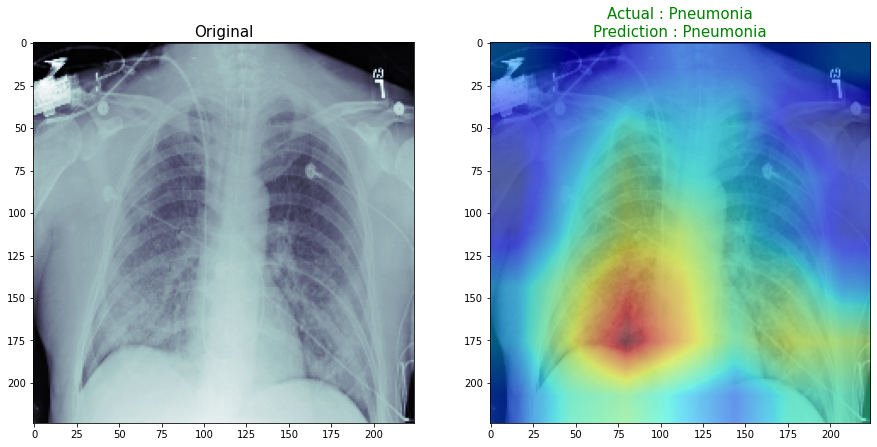

In [145]:
visualize(img, activation_map1, pred1, label)

In [147]:
for img, label in val_dataset:
    if label == 0:
        last_img , last_label = img, label
        break

In [148]:
activation_map2,pred2 = cam(model, last_img)

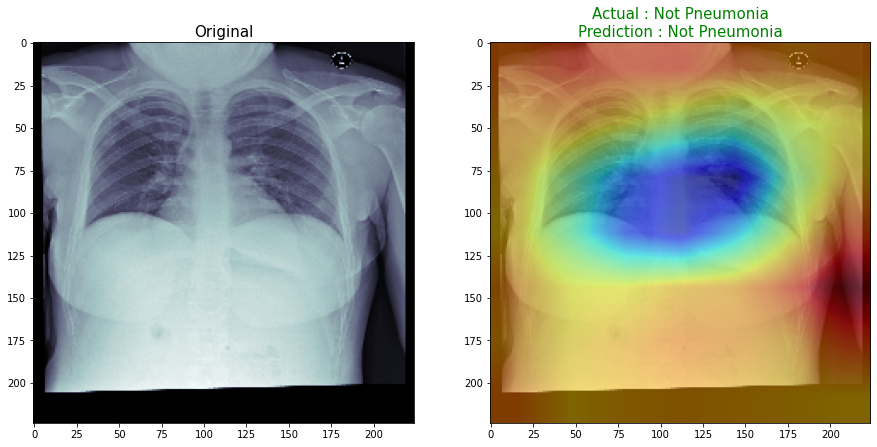

In [149]:
visualize(img, activation_map2, pred2, last_label)